# Lista 2

In [1]:
import sys
sys.path.append('..')
from fractions import Fraction

from IPython.display import display, Math
import numpy as np
import pandas as pd
from scipy.stats import binom
from scipy.integrate import simpson, cumulative_trapezoid
from scipy.fft import rfft
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from utils.math import quantile, safe_exp, normalize, beta_pdf, fftconvolution
from utils.sampling import inversion_sampling

## Questão 1

## Questão 2

### a)

Quando o dado não é enviesado, a verossimilhança em $y$ é dada por

\begin{align*}
\mathbb{P}(y) &= \sum_{\theta_i \in \Omega(\theta)} \mathbb{P}(y | \theta = \theta_i, I) \mathbb{P}(\theta = \theta_i | I)\\
&= \mathbb{P}(y | \theta = 1/6, I)\\
& \sim \text{Binom}(y, 1/6)
\end{align*}

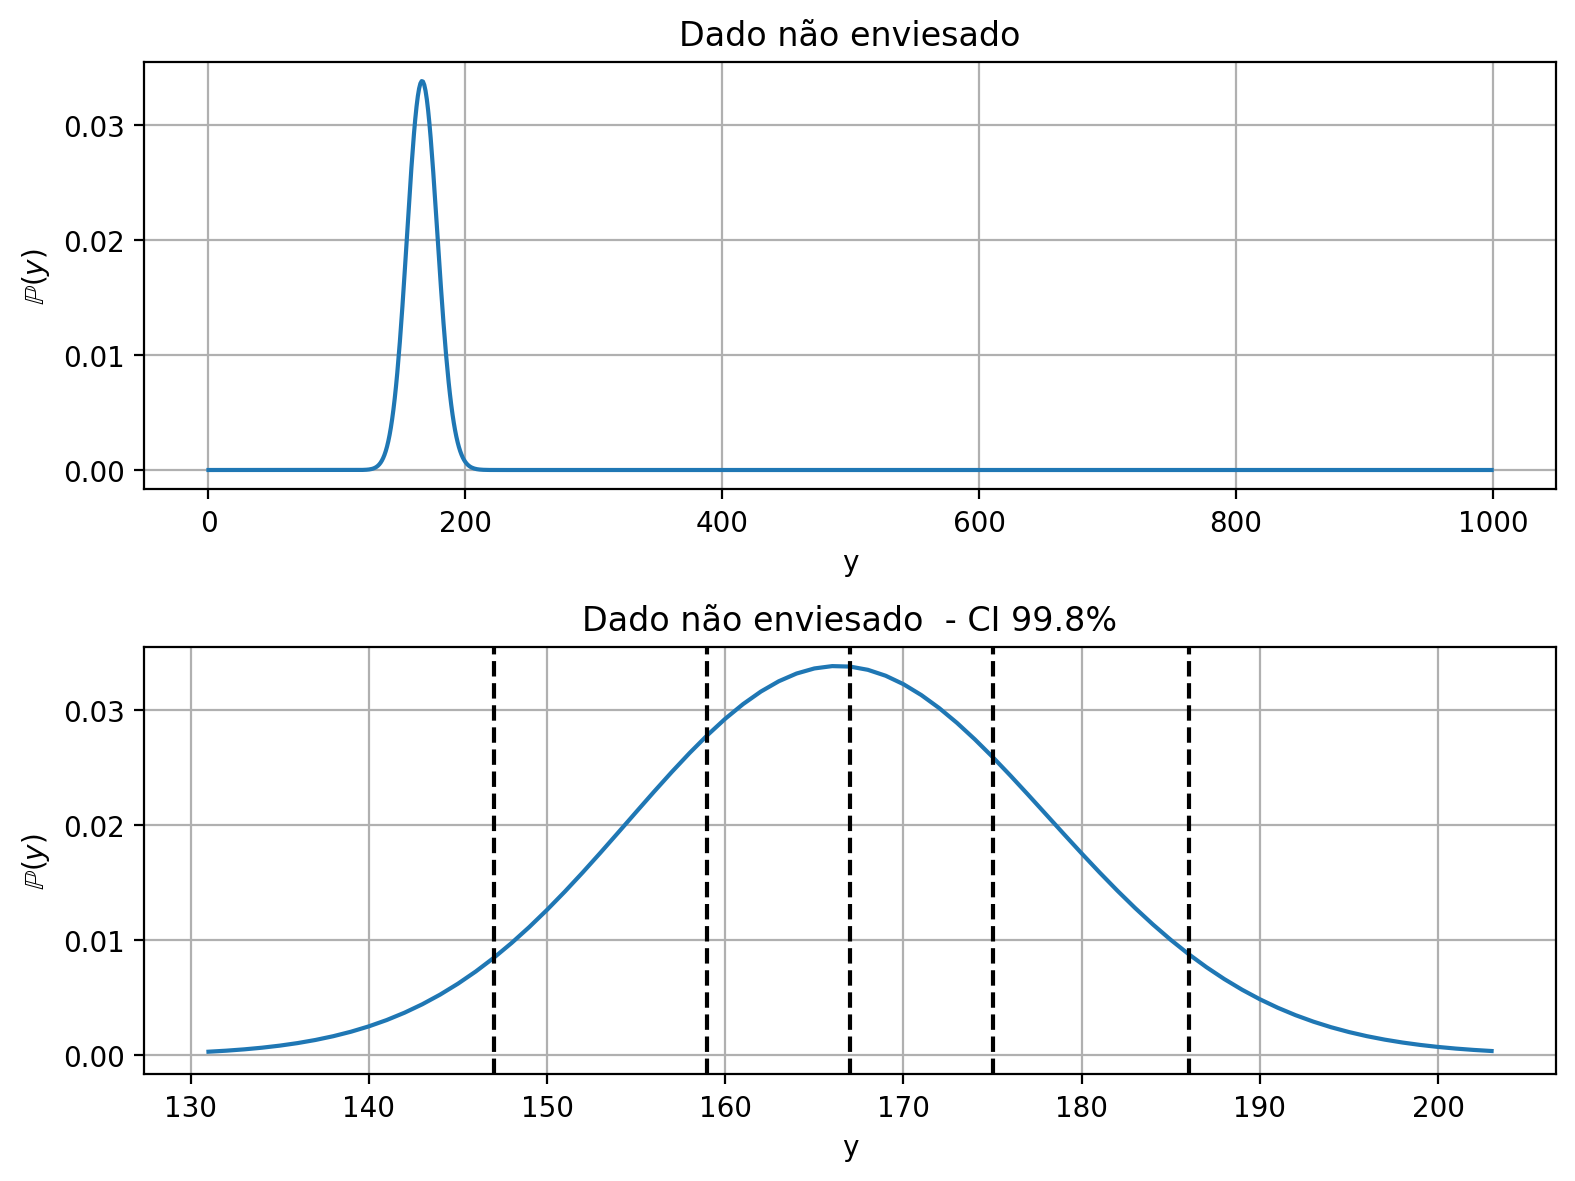

In [2]:
n = 1000
p = 1 / 6
y = np.arange(n)
zoomed_y = np.arange(binom.ppf(0.001, n, p), binom.ppf(0.999, n, p))

# Quantiles
qs = [0.05, 0.25, 0.50, 0.75, 0.95]
quantiles = quantile(binom.pmf(y, n, p), y, qs, discrete=True)

fig, axs = plt.subplots(2, 1, sharey=True, figsize=(8, 6))
axs[0].plot(y, binom.pmf(y, n, p))
axs[1].plot(zoomed_y, binom.pmf(zoomed_y, n, p))
for q in quantiles:
    axs[1].axvline(q, ls='--', c='k')

for ax in axs:
    ax.grid()
    ax.set_xlabel('y')
    ax.set_ylabel(r'$\mathbb{P}(y)$')
axs[0].set_title('Dado não enviesado')
axs[1].set_title('Dado não enviesado  - CI 99.8%')
fig.tight_layout()
plt.show()

In [3]:
theo_quantiles = binom.ppf(qs, n, p)
# Compare quantile computation with theoretical given by scipy.stats.binom.ppf
assert all(abs(quantiles - theo_quantiles) < 1e-3)

for pq, q in zip(qs, quantiles):
    display(Math(r'\mathbb{P}(y \leq q) = ' + r'{0} \Rightarrow q = {1:.2f}'.format(pq, q)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### b)

\begin{align*}
\mathbb{P}(y) &= \sum_{\theta_i \in \Omega(\theta)} \mathbb{P}(y | \theta = \theta_i, I) \mathbb{P}(\theta = \theta_i | I)\\
&= \mathbb{P}(y | \theta = 1 / 12, I) \mathbb{P}(\theta = 1/ 12 | I) + \mathbb{P}(y | \theta = 1 / 6, I) \mathbb{P}(\theta = 1/ 6 | I) + \mathbb{P}(y | \theta = 1 / 4, I) \mathbb{P}(\theta = 1/ 4 | I)\\
&= 0.25\mathbb{P}(y | \theta = 1 / 12, I) + 0.5\mathbb{P}(y | \theta = 1 / 6, I) + 0.25\mathbb{P}(y | \theta = 1 / 4, I)
\end{align*}

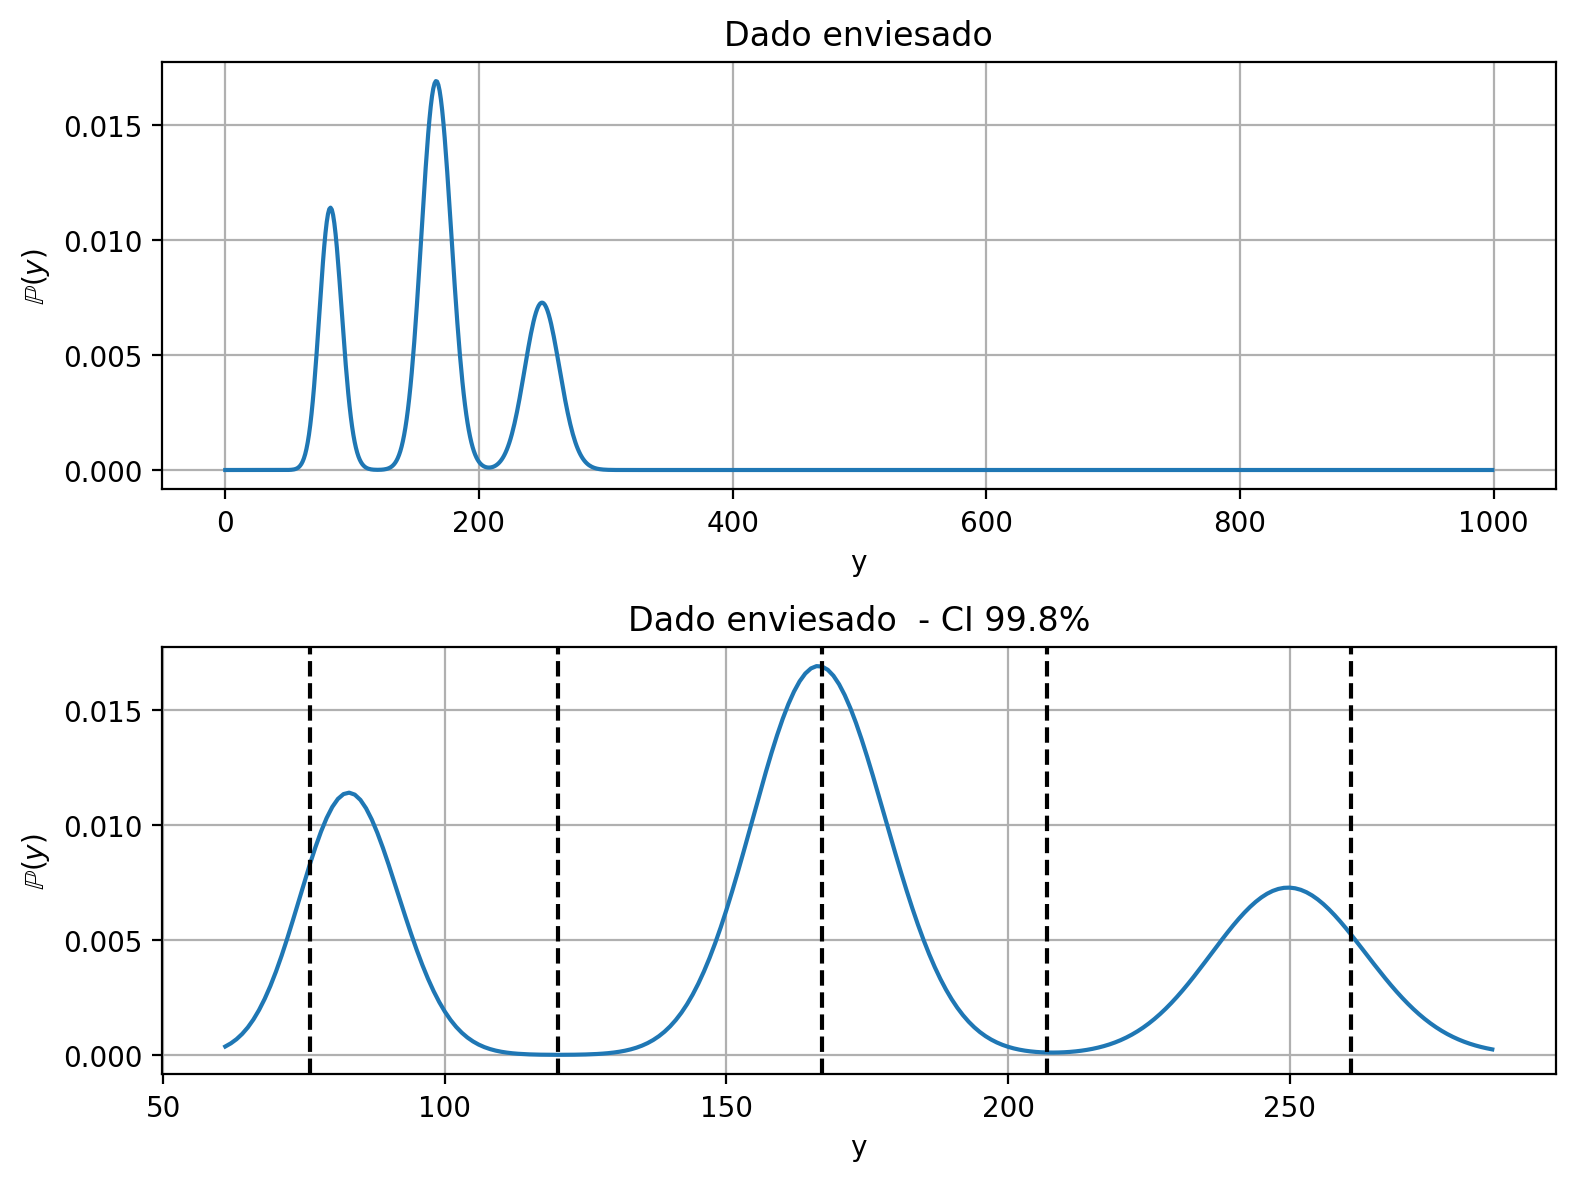

In [4]:
n = 1000
y = np.arange(n)
def pmf(k, n):
    return 0.25 * binom.pmf(k, n, 1 / 12) + 0.5 * binom.pmf(k, n, 1 / 6) + 0.25 * binom.pmf(k, n, 1 / 4)

qs = [0.05, 0.25, 0.50, 0.75, 0.95]
quantiles = quantile(pmf(y, n), y, qs, discrete=True)
ymin, ymax = quantile(pmf(y, n), y, [0.001, 0.999], discrete=True)
zoomed_y = np.arange(ymin, ymax)

fig, axs = plt.subplots(2, 1, sharey=True, figsize=(8, 6))
axs[0].plot(y, pmf(y, n))
axs[1].plot(zoomed_y, pmf(zoomed_y, n))
for q in quantiles:
    axs[1].axvline(q, ls='--', c='k')

for ax in axs:
    ax.grid()
    ax.set_xlabel('y')
    ax.set_ylabel(r'$\mathbb{P}(y)$')
axs[0].set_title('Dado enviesado')
axs[1].set_title('Dado enviesado  - CI 99.8%')
fig.tight_layout()
plt.show()

In [5]:
for pq, q in zip(qs, quantiles):
    display(Math(r'\mathbb{P}(y \leq q) = ' + r'{0} \Rightarrow q = {1:.2f}'.format(pq, q)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

## Questão 3

### a)

Seja $\theta_i$ o ângulo que o segmento $\overline{FP_i} = (x_i, 0) - (x_F, y_F)$ faz com a vertical $\overline{FH} = (x_F, 0)- (x_F, y_F)$. A relação geométrica entre esses pontos é dada por

$$ x_i = x_F + y_F \tan\theta_i $$

Quando $\theta_i = 0$, o pulso é detectado diretamente na frente do farol, $x_i = x_F$. Já os limites $x_i \to \pm \infty$ correspondem a $\theta_i \to \pm \pi/2$. A informação que tem-se sobre a direção dos pulsos é que $\theta_i \sim \mathcal{U}(-\pi/2, \pi/2)$. Portanto,

\begin{align*}
\mathbb{P}(X_i \leq x | x_F, y_F) &= \mathbb{P}(x_F + y_F \tan\theta_i \leq x | x_F, y_F)\\
&= \mathbb{P}\left(\theta_i \leq \arctan \left[\frac{x - x_F}{y_F}\right] \Bigg| x_F, y_F \right)\\
&= \frac{1}{\pi} \arctan \left[\frac{x - x_F}{y_F}\right]
\end{align*}

A p.d.f $p(x)$ é dada por

\begin{align*}
p(x) &= \frac{d}{dx}\mathbb{P}(X_i \leq x | x_F, y_F) \\
&= \frac{1}{\pi}  \frac{d}{dx} \arctan \left[\frac{x - x_F}{y_F}\right]\\
&= \frac{1}{\pi} \frac{y_F}{y_F^2 + (x - x_F)^2},
\end{align*}

que corresponde a uma curva Lorentzianna.

### b)

Pelo teorema de Bayes,

\begin{align*}
\mathbb{P}(x_F | \{x_i\}, y_F) & \propto \prod_i \mathbb{P}(x_i | x_F, y_F) \mathbb{P}(x_F | y_F)\\
&\propto \prod_i \frac{1}{1 + (x_i - x_F)^2}
\end{align*}

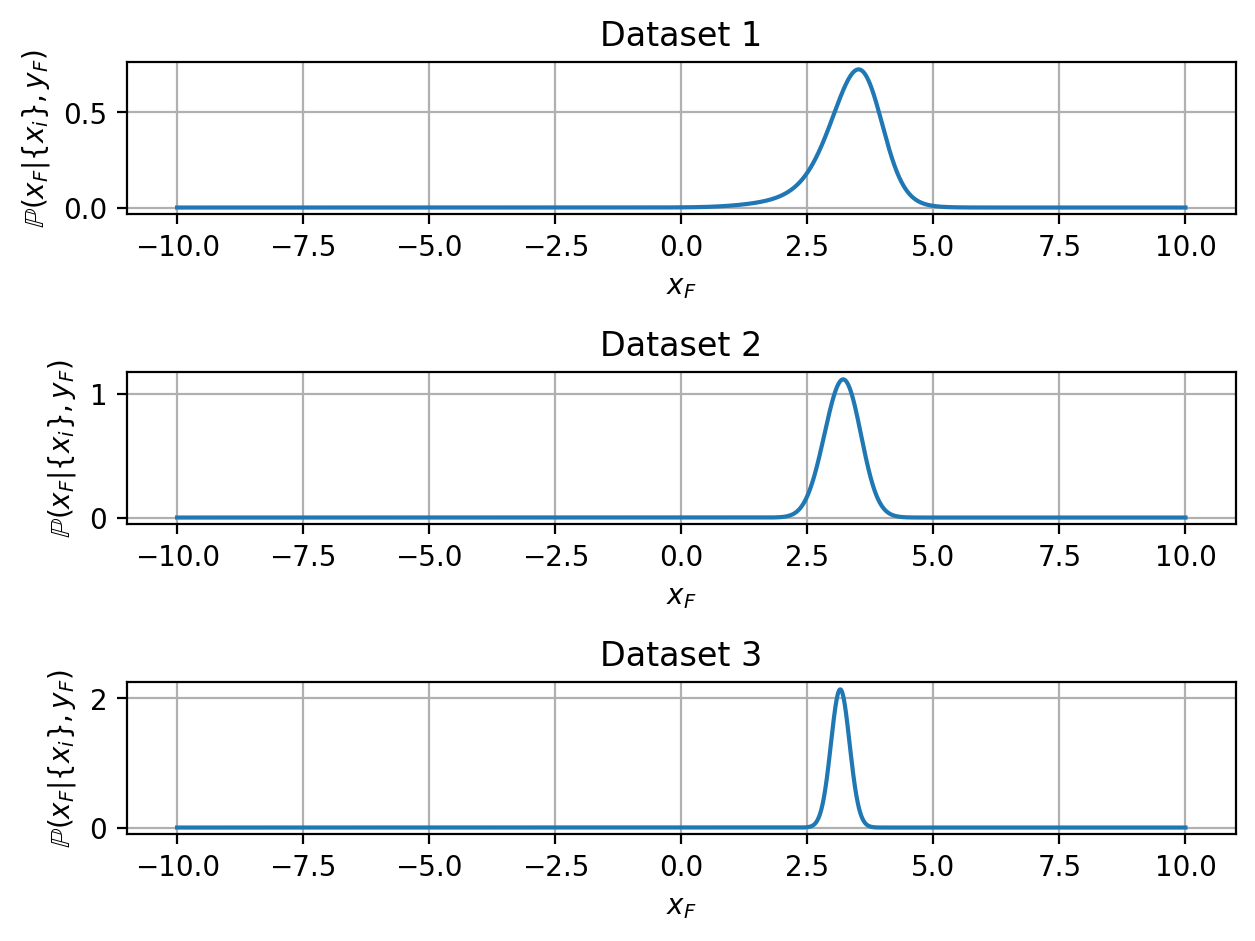

In [6]:
def loglike(xi, xf, yf):
    return - np.log(yf ** 2 + (xi - xf) ** 2)

def logprob(dataset, xf, yf, prior=1.):
    return np.sum([loglike(xi, xf, yf) for xi in dataset], axis=0) + np.log(prior)

def prob(dataset, xf, yf, **kwargs):
    return normalize(safe_exp(logprob(dataset, xf, yf, **kwargs)), xf)

nx = 10000
yf = 1
xf = np.linspace(-10, 10, nx)

# Getting datasets
ndatasets = 3
dts = [np.loadtxt(f'../data/pb2/q3ds{i + 1}.txt') for i in range(ndatasets)]

fig, axs = plt.subplots(3, 1)
for i, ax in enumerate(axs):
    ax.plot(xf, prob(dts[i], xf, yf))
    ax.grid()
    ax.set_title(f'Dataset {i + 1}')
    ax.set_xlabel(r'$x_F$')
    ax.set_ylabel(r'$\mathbb{P}(x_F | \{x_i \}, y_F)$')

fig.tight_layout()
plt.show()

## Questão 5

Calculamos a p.d.f da média $\overline{X} = n^{-1}\sum_{i=1}^n X_i$ de duas maneiras:

1) Amostrando $x_i^j \sim \mathcal{B}(\alpha, \beta)$ e montando um histograma da média amostral

Usamos uma técnica simples de *inversion sampling*, em que $N \times n \ll 1$ variáveis $U_i \sim \mathcal{U}(0, 1)$ são tiradas, e inverte-se a relação $\mathbb{P}(X \leq x_i) = u_i$ para obter $x_i$. É possível demonstrar então que $x_i \sim \mathcal{B}(\alpha, \beta)$. Em seguida, calcula-se a média amostral

$$ \overline{x}^j = \frac{1}{n}\sum_{i=1}^n x_i^j,$$

para $j \in 1, \ldots, N$. Finalmente, aproximamos a pdf $p_{\overline{X}}$ com um histograma (normalizado) das amostras $\overline{x}^j$, já que essas são independentes.


2) Usando o teorema da convolução: calculando numericamente a FFT de $\mathcal{B}(\alpha, \beta)$, e depois a FFT inversa de $\mathcal{F}[\mathcal{B}(\alpha, \beta)]^n$

Como as variáveis são independentes, a pdf da sua soma é dada pela convolução das suas pdfs, que é mais facilmente calculada usando a transformada de Fourier:

$$p_{\overline{X}_n} \propto \mathcal{F}^{-1}[\mathcal{F}[p_X]^n]$$

A implementação dessa técnica é direta, porém é preciso se atentar a alguns detalhes. Ao calcular a transformada de Fourier discreta (DFT) do vetor de $p_X$, deve-se concatenar um número de zeros ao final deste (*zero-padding*). A quantidade de zeros depende de $n$: o tamanho total do vetor modificado de $p_X$ deve ser $n \, \text{len}(p_X) -n+1$, que é o tamanho do vetor resultante da DFT inversa após $n - 1$ auto-convoluções. Esse método está implementado na função `utils.math.fftconvolution`.

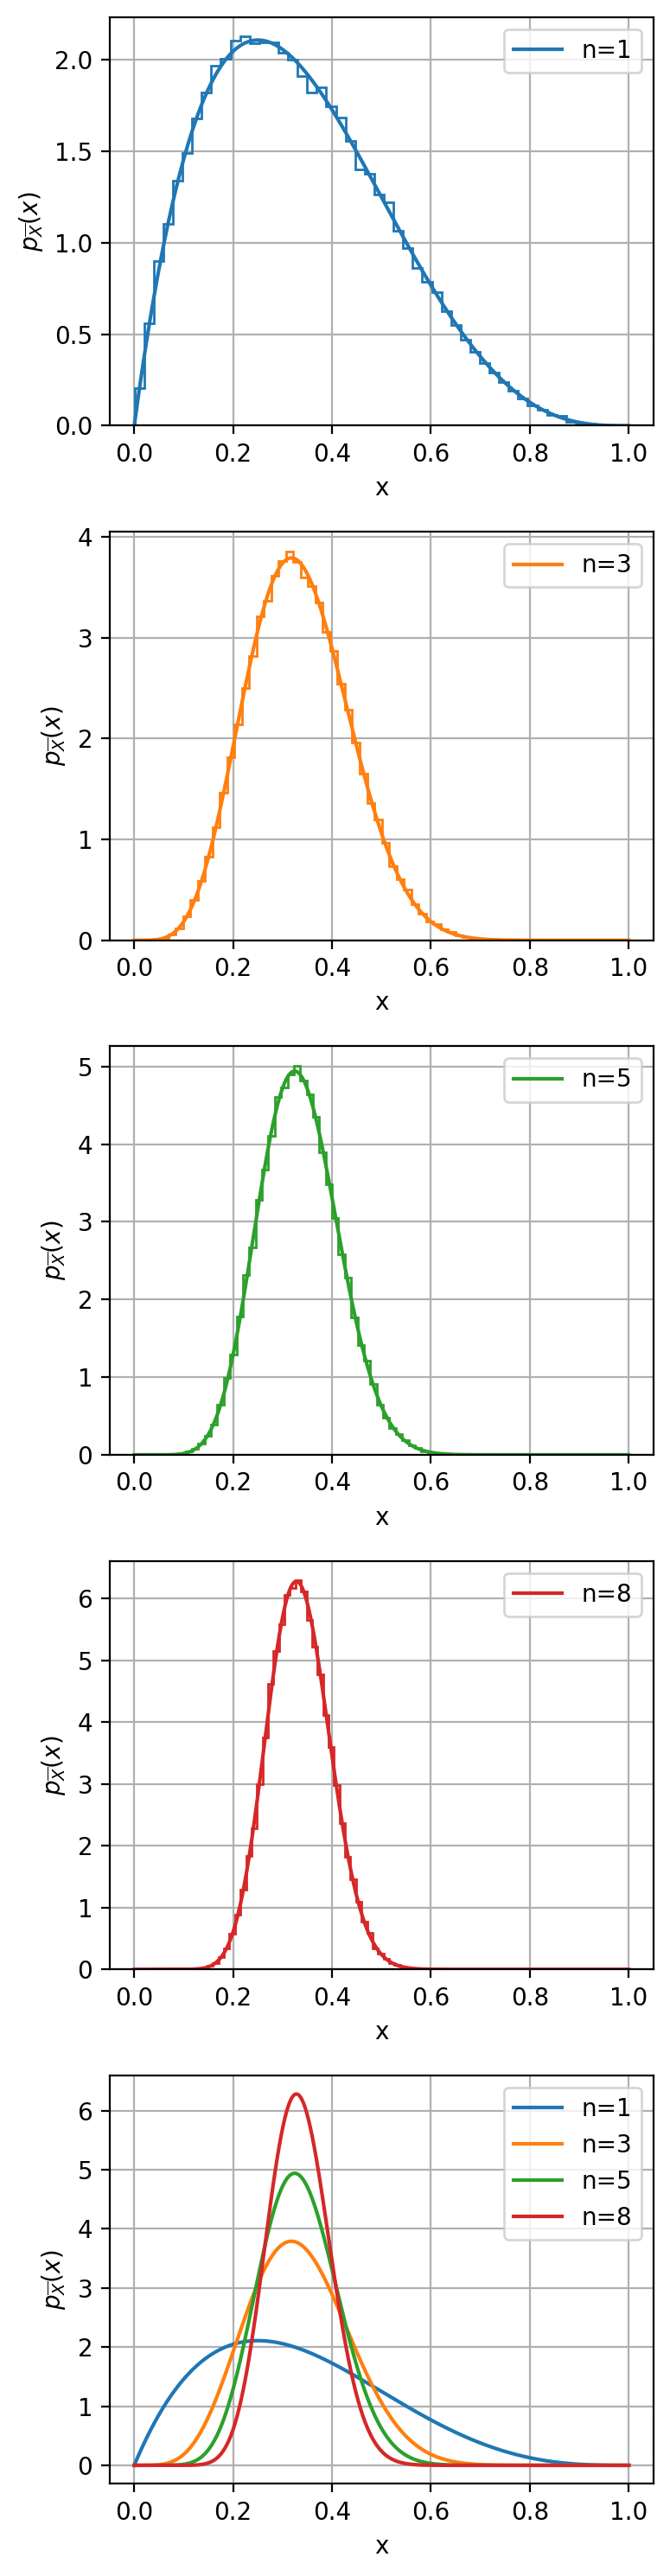

In [19]:
def average_pdf_inversion_sampling(n, alpha, beta, x, nsamples):
    pdf = beta_pdf(x, alpha, beta)
    samples = inversion_sampling(pdf, x, n * nsamples).reshape((n, nsamples))
    return np.mean(samples, axis=0)

nvec = [1, 3, 5, 8]
nfig = len(nvec) + 1
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
alpha, beta = 2, 4
nsamples = 100000
nbins = 50
ns = 10000
x = np.linspace(0, 1, ns)
pdf = beta_pdf(x, alpha, beta)
fig, axs = plt.subplots(nfig, 1, figsize=(4, 3 * nfig))
convolved_pdfs = []
for n, c, ax in zip(nvec, colors, axs):
    samples = average_pdf_inversion_sampling(n, alpha, beta, x, nsamples)
    ax.hist(samples, nbins, density=True, histtype='step', color=c)
    convolved_pdf, fft_size = fftconvolution(pdf, n)
    xplot = np.linspace(0, 1, fft_size)
    convolved_pdf = normalize(convolved_pdf, xplot)
    ax.plot(xplot, convolved_pdf, color=c, label=f'n={n}')
    axs[-1].plot(xplot, convolved_pdf, color=c, label=f'n={n}')
    ax.grid()
    ax.legend()
    ax.set_xlabel('x')
    ax.set_ylabel(r'$p_{\overline{X}}(x)$')
    # ax.set_title(f'n={n}')

axs[-1].grid()
axs[-1].legend()
axs[-1].set_xlabel('x')
axs[-1].set_ylabel(r'$p_{\overline{X}}(x)$')

fig.tight_layout()
plt.show()